In [16]:
import os
import numpy as np
import imageio
from IPython.display import clear_output
import optuna
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
from attractors import Attractor
from sklearn.cluster import KMeans

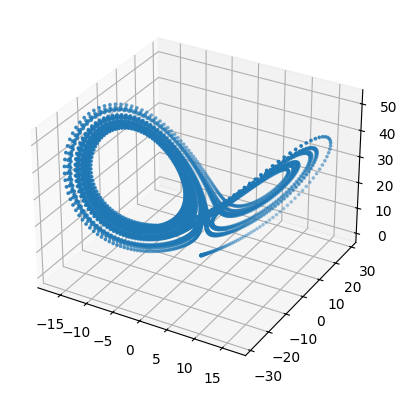

In [17]:
attr = Attractor("lorenz").rk4(0, 30, 5000)
df_lorenz = np.array([[i.X, i.Y, i.Z] for i in attr])
ax = plt.axes(projection="3d")
# ax.view_init(elev=20, azim=-70)
ax.scatter3D(df_lorenz.T[0], df_lorenz.T[1], df_lorenz.T[2], s=3)
plt.show()

The key idea is using Neiborhood Reconstruction. This method preserve the local geometry of the original data ditribution. First of all let's introduce the loss function.
$$
\mathcal{L}(\theta, \phi; \mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{x \in \mathcal{D}} \frac{1}{|\mathcal{N}(x)|} \sum_{x' \in \mathcal{N}(x)} K(x', x) \cdot \|x' - \tilde{F}_{\theta,\phi}(x';x)\|^2
$$
where $K(x', x)$ is a positive symmetric kernel function that determines the weight for each $x' \in \mathcal{N}(x)$. We choose the following simple kernel
\begin{equation}
K(x', x) = \lambda + (1-\lambda)\delta(x', x),
\end{equation}
where $0 < \lambda < 1$ and $\delta(x', x) = 1$ if $x' = x$ and zero otherwise. This assigns the weight $1$ for the center $x \in \mathcal{N}(x)$ and the weight $\lambda$ for the remaining neighborhood points.

In case where we want to use information about linear in the neighborhood of the point, we may use the Jacobian of the function.

In [18]:
def get_kernel_function(kernel):
    if kernel['type'] == 'binary':
        def kernel_func(x_center, x_neighbors):
            batch_size = x_neighbors.size(0)
            num_neighbors = x_neighbors.size(1)
            x_center = x_center.view(batch_size, -1)
            x_neighbors = x_neighbors.view(batch_size, num_neighbors, -1)
            eps = 1.0e-12
            index = torch.norm(x_center.unsqueeze(1)-x_neighbors, dim=2) > eps
            output = torch.ones(batch_size, num_neighbors).to(x_center)
            output[index] = kernel['lambda']
            return output
    return kernel_func

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        loss = ((recon - x) ** 2).view(len(x), -1).mean(dim=1).mean()
        mse_loss = F.mse_loss(recon, x)
        return {"recon": recon, "loss": loss, 'mse_loss': mse_loss}


class NRAE(AE):
    def __init__(self, encoder, decoder, approx_order=1, kernel=None):
        super().__init__(encoder, decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.approx_order = approx_order
        self.kernel_func = get_kernel_function(kernel)

    def jacobian(self, z, dz, create_graph=True):
        batch_size = dz.size(0)
        num_neighbors = dz.size(1)
        z_dim = dz.size(2)

        v = dz.view(-1, z_dim)
        inputs = (z.unsqueeze(1).repeat(1, num_neighbors, 1).view(-1, z_dim))
        jac = torch.autograd.functional.jvp(self.decoder, inputs, v=v, create_graph=create_graph)[1].view(batch_size, num_neighbors, -1)
        return jac

    def jacobian_and_hessian(self, z, dz, create_graph=True):
        batch_size = dz.size(0)
        num_neighbors = dz.size(1)
        z_dim = dz.size(2)

        v = dz.view(-1, z_dim)
        inputs = (z.unsqueeze(1).repeat(1, num_neighbors, 1).view(-1, z_dim))

        def jac_temp(inputs):
            jac = torch.autograd.functional.jvp(self.decoder, inputs, v=v, create_graph=create_graph)[1].view(batch_size, num_neighbors, -1)
            return jac

        temp = torch.autograd.functional.jvp(jac_temp, inputs, v=v, create_graph=create_graph)

        jac = temp[0].view(batch_size, num_neighbors, -1)
        hessian = temp[1].view(batch_size, num_neighbors, -1)
        return jac, hessian
        
    def neighborhood_recon(self, z_center, z_neighbors):
        recon = self.decoder(z_center)
        recon_flat = recon.view(z_center.size(0), -1).unsqueeze(1)
        dz = z_neighbors - z_center.unsqueeze(1)
        
        if self.approx_order == 1:
            jacobian_dz = self.jacobian(z_center, dz)
            neighbor_recon = recon_flat + jacobian_dz
        elif self.approx_order == 2:
            jacobian_dz, dz_hessian_dz = self.jacobian_and_hessian(z_center, dz)
            neighbor_recon = recon_flat + jacobian_dz + 0.5*dz_hessian_dz
            
        return neighbor_recon

    def forward(self, x_center, x_neighbors=None):
        z_center = self.encoder(x_center)
        recon = self.decoder(z_center)
        
        if x_neighbors is None:
            loss = ((recon - x_center) ** 2).view(len(x_center), -1).mean(dim=1).mean()
            return {"recon": recon, "loss": loss}
        
        batch_size = x_neighbors.size(0)
        num_neighbors = x_neighbors.size(1)
        z_dim = z_center.size(1)
        
        z_neighbors = self.encoder(x_neighbors.view([-1] + list(x_neighbors.size()[2:]))).view(batch_size, -1, z_dim)
        neighbor_recon = self.neighborhood_recon(z_center, z_neighbors)
        neighbor_loss = torch.norm(x_neighbors.view(batch_size, num_neighbors, -1) - neighbor_recon, dim=2)**2
        weights = self.kernel_func(x_center, x_neighbors)
        loss = (weights*neighbor_loss).mean()
        mse_loss = F.mse_loss(recon, x_center)
        
        return {"recon": recon, "loss": loss, "mse_loss": mse_loss}


l_sz = 16

def get_encoder(d_input=3, d_latent=1, layer_sz=l_sz, alpha=0.5):
    encoder = nn.Sequential(
        nn.Linear(d_input, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_latent)
    )
    return encoder

def get_decoder(d_latent=1, d_output=3, layer_sz=l_sz, alpha=0.5):
    decoder = nn.Sequential(
        nn.Linear(d_latent, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_output)
    )
    return decoder

In [19]:
class Dataset(Dataset):
   def __init__(self, data, targets=None):
       self.data = torch.from_numpy(data).float()

       self.targets = torch.from_numpy(targets).float() if targets is not None else None

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       if self.targets is not None:
           return self.data[idx], self.targets[idx]
       else:
           return self.data[idx]

In [20]:
lorenz_dataset = Dataset(df_lorenz)
data_loader = DataLoader(lorenz_dataset, batch_size=256, shuffle=True)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

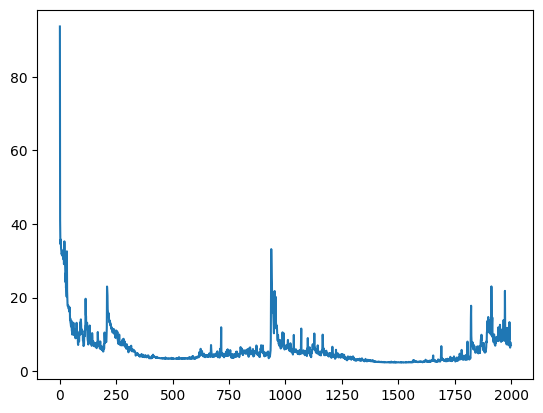

[I 2025-03-29 16:49:22,552] Trial 6 finished with value: 5.913714446552843 and parameters: {'hidden_dim': 256, 'learning_rate': 0.0007030785448685911}. Best is trial 6 with value: 5.913714446552843.



Trial 7
Current parameters: {'hidden_dim': 32, 'learning_rate': 0.07088363524285224}


  0%|          | 0/2000 [00:00<?, ?it/s]
[I 2025-03-29 16:49:22,586] Trial 7 pruned. 



Trial 8
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.010705592709537002}


  0%|          | 0/2000 [00:00<?, ?it/s]
[I 2025-03-29 16:49:22,668] Trial 8 pruned. 



Trial 9
Current parameters: {'hidden_dim': 8, 'learning_rate': 0.04218867048246216}


  1%|          | 13/2000 [00:00<00:48, 40.55it/s]
[I 2025-03-29 16:49:22,990] Trial 9 pruned. 


Best trial:
  Value:  5.913714446552843
  Params: 
    hidden_dim: 256
    learning_rate: 0.0007030785448685911


In [22]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=128,
        shuffle=True
    )

    model = AE(
        encoder=get_encoder(3, 1, params['hidden_dim']),
        decoder=get_decoder(1, 3, params['hidden_dim']),
    ).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=500,
        eta_min=1e-6
    )


    criterion = nn.MSELoss()
    
    n_epochs = 2000
    losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_losses = []
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            recon = output['recon']
            loss = output['loss']
            mse_loss = output['mse_loss']
            loss.backward()
            optimizer.step()
            epoch_losses.append(mse_loss.item())

        scheduler.step(epoch)

        trial.report(np.mean(epoch_losses), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        losses.append(np.mean(epoch_losses))

    output = model(lorenz_dataset.data.to(device))
    recon = np.array(output['recon'].data.cpu())
    
    clear_output()

    # ax = plt.axes(projection="3d")
    # ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)
    
    plt.plot(losses)
    plt.show()

    return np.mean(losses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = AE(
    encoder=get_encoder(3, 1, best_params['hidden_dim']),
    decoder=get_decoder(1, 3, best_params['hidden_dim']),
).to(device)
best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
)

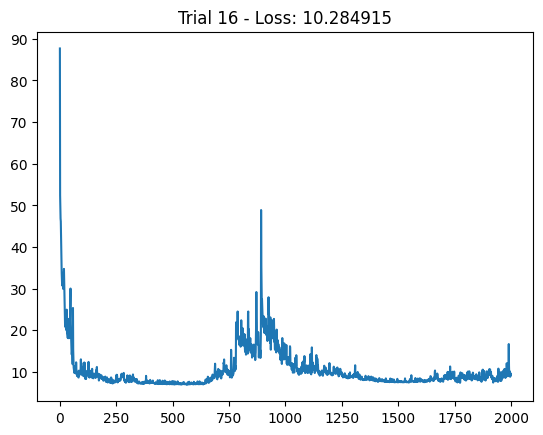

[I 2025-03-29 18:16:07,451] Trial 16 finished with value: 10.284915129466356 and parameters: {'hidden_dim': 256, 'learning_rate': 0.0008050032812300506, 'lambda': 0.19388597739198823, 'num_neighbors': 9}. Best is trial 11 with value: 10.257554585050046.



Trial 17
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.0007137354094892644, 'lambda': 1.4255132539690607, 'num_neighbors': 8}


 15%|█▌        | 302/2000 [01:53<10:36,  2.67it/s]
[I 2025-03-29 18:18:00,669] Trial 17 pruned. 



Trial 18
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.00043812211206457284, 'lambda': 0.2519241807603736, 'num_neighbors': 14}


  1%|          | 15/2000 [00:09<20:33,  1.61it/s]
[I 2025-03-29 18:18:09,995] Trial 18 pruned. 



Trial 19
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.004161204531204401, 'lambda': 0.6400560380740897, 'num_neighbors': 8}


  7%|▋         | 139/2000 [00:20<04:38,  6.68it/s]
[I 2025-03-29 18:18:30,818] Trial 19 pruned. 


Best trial:
  Value:  10.257554585050046
  Params: 
    hidden_dim: 64
    learning_rate: 0.0021892368519214967
    lambda: 0.0990480997519888
    num_neighbors: 9

Training best model...


  0%|          | 1/5000 [00:00<12:19,  6.76it/s]

Epoch 0, Loss: 120.498355


  2%|▏         | 102/5000 [00:15<11:59,  6.81it/s]

Epoch 100, Loss: 14.679377


  4%|▍         | 202/5000 [00:30<11:46,  6.79it/s]

Epoch 200, Loss: 9.652016


  6%|▌         | 302/5000 [00:44<11:36,  6.75it/s]

Epoch 300, Loss: 9.125148


  8%|▊         | 402/5000 [00:59<11:16,  6.80it/s]

Epoch 400, Loss: 8.052433


 10%|█         | 502/5000 [01:14<11:04,  6.77it/s]

Epoch 500, Loss: 7.643556


 12%|█▏        | 602/5000 [01:29<11:20,  6.46it/s]

Epoch 600, Loss: 7.865421


 14%|█▍        | 702/5000 [01:44<10:45,  6.66it/s]

Epoch 700, Loss: 7.539415


 16%|█▌        | 802/5000 [02:01<10:17,  6.79it/s]

Epoch 800, Loss: 11.286305


 18%|█▊        | 902/5000 [02:16<10:01,  6.82it/s]

Epoch 900, Loss: 12.607553


 20%|██        | 1002/5000 [02:30<09:44,  6.84it/s]

Epoch 1000, Loss: 9.147271


 22%|██▏       | 1102/5000 [02:46<11:10,  5.82it/s]

Epoch 1100, Loss: 8.483739


 24%|██▍       | 1202/5000 [03:02<09:35,  6.60it/s]

Epoch 1200, Loss: 8.711093


 26%|██▌       | 1302/5000 [03:19<09:54,  6.22it/s]

Epoch 1300, Loss: 15.897875


 28%|██▊       | 1402/5000 [03:35<09:07,  6.57it/s]

Epoch 1400, Loss: 12.833327


 30%|███       | 1502/5000 [03:51<08:51,  6.59it/s]

Epoch 1500, Loss: 12.159546


 32%|███▏      | 1602/5000 [04:07<08:35,  6.59it/s]

Epoch 1600, Loss: 12.091792


 34%|███▍      | 1702/5000 [04:25<09:07,  6.03it/s]

Epoch 1700, Loss: 16.493859


 36%|███▌      | 1802/5000 [04:43<09:49,  5.43it/s]

Epoch 1800, Loss: 11.341231


 38%|███▊      | 1902/5000 [04:59<07:41,  6.71it/s]

Epoch 1900, Loss: 10.551749


 40%|████      | 2002/5000 [05:15<07:25,  6.73it/s]

Epoch 2000, Loss: 11.716330


 42%|████▏     | 2102/5000 [05:31<07:22,  6.55it/s]

Epoch 2100, Loss: 14.379072


 44%|████▍     | 2201/5000 [05:51<12:20,  3.78it/s]

Epoch 2200, Loss: 13.173410


 46%|████▌     | 2302/5000 [06:19<07:32,  5.97it/s]

Epoch 2300, Loss: 15.403709


 48%|████▊     | 2401/5000 [06:42<11:53,  3.64it/s]

Epoch 2400, Loss: 16.707664


 50%|█████     | 2501/5000 [07:10<11:28,  3.63it/s]

Epoch 2500, Loss: 13.229387


 52%|█████▏    | 2601/5000 [07:38<10:46,  3.71it/s]

Epoch 2600, Loss: 13.780366


 54%|█████▍    | 2701/5000 [08:07<11:33,  3.32it/s]

Epoch 2700, Loss: 11.356950


 56%|█████▌    | 2801/5000 [08:37<10:46,  3.40it/s]

Epoch 2800, Loss: 12.188803


 58%|█████▊    | 2901/5000 [09:04<08:56,  3.91it/s]

Epoch 2900, Loss: 11.717361


 60%|██████    | 3001/5000 [09:30<08:19,  4.00it/s]

Epoch 3000, Loss: 14.866493


 62%|██████▏   | 3101/5000 [09:58<08:53,  3.56it/s]

Epoch 3100, Loss: 10.282104


 64%|██████▍   | 3201/5000 [10:27<07:43,  3.89it/s]

Epoch 3200, Loss: 8.382431


 66%|██████▌   | 3301/5000 [10:54<08:43,  3.24it/s]

Epoch 3300, Loss: 6.862432


 68%|██████▊   | 3401/5000 [11:22<08:08,  3.27it/s]

Epoch 3400, Loss: 5.808266


 70%|███████   | 3501/5000 [11:51<06:49,  3.66it/s]

Epoch 3500, Loss: 5.329000


 72%|███████▏  | 3601/5000 [12:18<06:03,  3.85it/s]

Epoch 3600, Loss: 5.485621


 74%|███████▍  | 3701/5000 [12:45<05:36,  3.86it/s]

Epoch 3700, Loss: 6.667451


 76%|███████▌  | 3801/5000 [13:13<05:25,  3.68it/s]

Epoch 3800, Loss: 6.625144


 78%|███████▊  | 3901/5000 [13:40<04:46,  3.84it/s]

Epoch 3900, Loss: 13.410437


 80%|████████  | 4001/5000 [14:08<04:51,  3.43it/s]

Epoch 4000, Loss: 10.833721


 82%|████████▏ | 4101/5000 [14:36<03:45,  3.98it/s]

Epoch 4100, Loss: 8.456468


 84%|████████▍ | 4201/5000 [15:01<03:26,  3.86it/s]

Epoch 4200, Loss: 10.080702


 86%|████████▌ | 4301/5000 [15:28<03:16,  3.55it/s]

Epoch 4300, Loss: 16.029819


 88%|████████▊ | 4401/5000 [15:56<02:38,  3.79it/s]

Epoch 4400, Loss: 13.808590


 90%|█████████ | 4501/5000 [16:22<02:10,  3.83it/s]

Epoch 4500, Loss: 15.467902


 92%|█████████▏| 4601/5000 [16:49<01:41,  3.93it/s]

Epoch 4600, Loss: 15.372296


 94%|█████████▍| 4701/5000 [17:19<01:31,  3.25it/s]

Epoch 4700, Loss: 17.045684


 96%|█████████▌| 4801/5000 [17:50<00:59,  3.33it/s]

Epoch 4800, Loss: 11.696458


 98%|█████████▊| 4901/5000 [18:20<00:29,  3.32it/s]

Epoch 4900, Loss: 8.445459


100%|██████████| 5000/5000 [18:49<00:00,  4.43it/s]


In [23]:
def objective_nrae(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-2, 100, log=True),
        'num_neighbors': trial.suggest_int('num_neighbors', 5, 20)
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)

    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=128,
        shuffle=True
    )

    nbrs = NearestNeighbors(n_neighbors=params['num_neighbors']).fit(df_lorenz)

    model = NRAE(
        encoder=get_encoder(3, 1, params['hidden_dim']),
        decoder=get_decoder(1, 3, params['hidden_dim']),
        approx_order=1,
        kernel={'type': 'binary', 'lambda': params['lambda']}
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=500,
        eta_min=1e-6
    )

    n_epochs = 2000
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_losses = []
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            _, indices = nbrs.kneighbors(batch.cpu())
            x_nn = torch.tensor(df_lorenz[indices], dtype=torch.float, device=device)

            output = model(batch, x_nn)
            
            loss = output['loss']
            mse_loss = output.get('mse_loss', loss)
            
            loss.backward()
            optimizer.step()
            epoch_losses.append(mse_loss.item())

        scheduler.step()
        trial.report(np.mean(epoch_losses), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        losses.append(np.mean(epoch_losses))

    model.eval()
    with torch.no_grad():
        all_data = lorenz_dataset.data.to(device)
        _, indices = nbrs.kneighbors(all_data.cpu())
        x_nn = torch.tensor(df_lorenz[indices], dtype=torch.float, device=device)
        
        output = model(all_data, x_nn)
        recon = output['recon'].cpu().numpy()
    
    clear_output()

    plt.plot(losses)
    plt.title(f'Trial {trial.number} - Loss: {np.mean(losses):.6f}')
    plt.show()

    return np.mean(losses)


study = optuna.create_study(direction="minimize")
study.optimize(objective_nrae, n_trials=20)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params

nbrs = NearestNeighbors(n_neighbors=best_params['num_neighbors']).fit(df_lorenz)

best_model = NRAE(
    encoder=get_encoder(3, 1, best_params['hidden_dim']),
    decoder=get_decoder(1, 3, best_params['hidden_dim']),
    approx_order=1,
    kernel={'type': 'binary', 'lambda': best_params['lambda']}
).to(device)

best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)
best_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    best_optimizer,
    T_max=500,
    eta_min=1e-6
)

best_train_loader = DataLoader(
    lorenz_dataset,
    batch_size=128,
    shuffle=True
)

n_epochs = 5000
best_losses = []
num_neighbors = best_params.get('num_neighbors', 10)

print("\nTraining best model...")
for epoch in tqdm(range(n_epochs)):
    best_model.train()
    epoch_losses = []
    
    for batch in best_train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        
        _, indices = nbrs.kneighbors(batch.cpu())
        x_nn = torch.tensor(df_lorenz[indices], dtype=torch.float, device=device)
        
        output = best_model(batch, x_nn)
        
        loss = output['loss']
        mse_loss = output.get('mse_loss', loss)
        
        loss.backward()
        best_optimizer.step()
        epoch_losses.append(mse_loss.item())
    
    avg_loss = np.mean(epoch_losses)
    best_losses.append(avg_loss)
    best_scheduler.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")


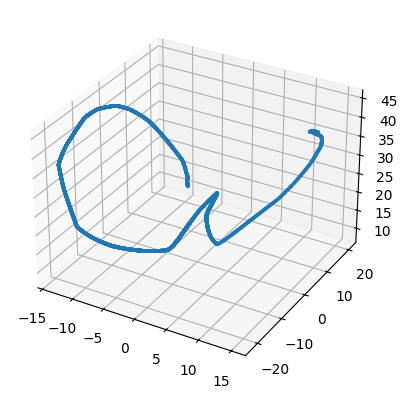

In [24]:
best_model.eval()
with torch.no_grad():
    all_data = lorenz_dataset.data.to(device)
    _, indices = nbrs.kneighbors(all_data.cpu())
    x_nn = torch.tensor(df_lorenz[indices], dtype=torch.float, device=device)
    
    output = best_model(all_data, x_nn)
    recon = output['recon'].cpu().numpy()

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)

    plt.show()

Here we use `torch.autograd.functional.jvp` to optimize the calculation of the Jacobian-vector product. It works in the following way: when we calculate the Jacobian matrix directly, we have to create the whole Jacobian matrix $n \times n$, which can be computationally expensive ($O(n^2)$). Instead of calculating the whole matrix, one can use the following trick: we can use the `grad_outputs` argument in `torch.autograd.grad` to apply weights to the gradients.

First, we calculate the outputs of the function.


```python
outputs = func(*inputs)
grad_outputs = tuple(
    torch.zeros_like(out, requires_grad=True)
    for out in outputs
)
```
We use these outputs as weights for the `grad_outputs` parameter. Then we can calculate the first backward pass.

```python
grad_x = torch.autograd.grad(
    outputs,
    x,
    grad_outputs=grad_outputs,
    create_graph=True
)[0]
```

After the first backward operation, we receive the linearization of the initial function at the given points. Then we perform the second backward pass.

```python
jvp = torch.autograd.grad(
    grad_x,
    grad_outputs,
    grad_outputs=v
)
```
Hence, the first backward pass computes the differential at the point, while the second computes the effect of the differential on the vector $v$. In our autoencoder, the vectors are the shifted neighbor vectors.

Simple example:

$$f(x) = x^2$$

$$\downarrow$$

$$\text{First backward}: \frac{\partial f}{\partial x} = 2x \cdot \text{grad\_outputs}$$

$$\downarrow$$

$$\text{Second backward: } \frac{\partial(2x \cdot \text{grad\_outputs})}{\partial \text{grad\_outputs}} \cdot v = 2x \cdot v$$